In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.models as models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from sklearn.model_selection import train_test_split


In [ ]:
pip install seaborn
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [18]:
print("PyTorch Version:", torch.__version__)
print(torch.cuda.is_available())
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")
if torch.cuda.is_available():
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

PyTorch Version: 2.1.2+cu121
True
Number of available GPUs: 1
GPU 0: NVIDIA T1000 8GB


In [19]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转 ±10 度
    transforms.RandomCrop(224, padding=4),  # 随机裁剪并填充
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # ImageNet 均值和标准差
])

transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

In [20]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
# 获取训练数据和标签
x_train = np.array(trainset.data)
y_train = np.array(trainset.targets)

print(f"训练数据形状: {x_train.shape}, 训练标签形状: {y_train.shape}")

训练数据形状: (50000, 32, 32, 3), 训练标签形状: (50000,)


In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

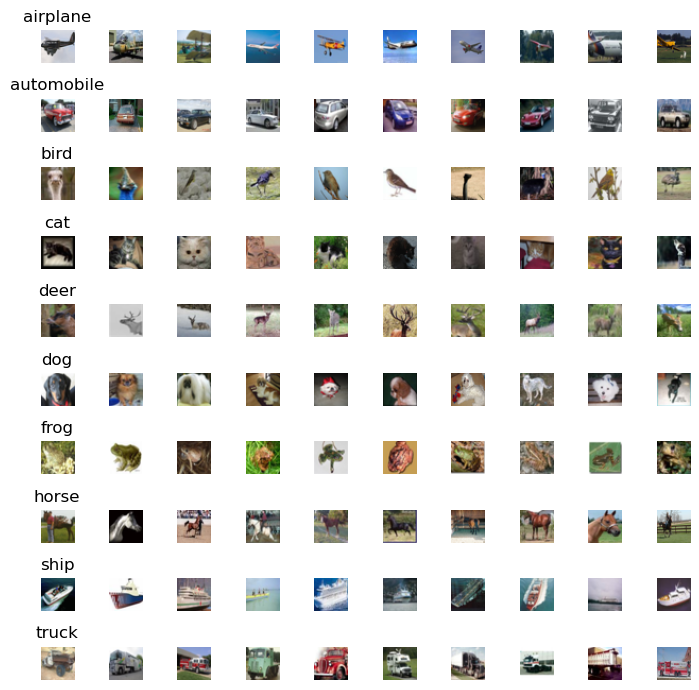

In [23]:
# 显示图像和标签
plt.figure(figsize=(7, 7))

for i, class_name in enumerate(class_names):
    # 找到属于该类别的图像索引
    indices = np.where(np.array(y_train) == i)[0]
    
    # 随机选择 10 张图像
    random_indices = np.random.choice(indices, 10, replace=False)
    
    for j, index in enumerate(random_indices):
        plt.subplot(len(class_names), 10, i * 10 + j + 1)
        plt.imshow(x_train[index])
        plt.axis('off')  # 不显示坐标轴
        if j == 0:
            plt.title(class_name)  # 只在第一列显示类别名称

plt.tight_layout()
plt.show()

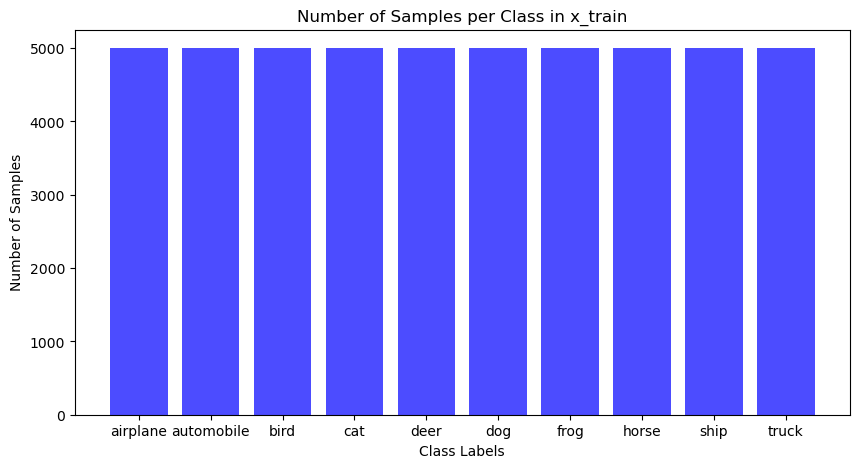

In [24]:
# 统计每个类别的样本数量
unique, counts = np.unique(y_train, return_counts=True)

# 创建柱状图
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='blue', alpha=0.7)

# 设置 x 轴和 y 轴标签
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in x_train')

# 设置 x 轴的刻度
plt.xticks(unique, class_names)

# 显示图形
plt.show()

In [25]:
# 按比例分割训练集和验证集
labels = trainset.targets
val_ratio = 0.2  # 设置验证集所占比例（20%）

# 获取训练集索引
train_indices = list(range(len(trainset)))

# 随机分割出验证集
train_indices, val_indices = train_test_split(
    train_indices,
    test_size=val_ratio,
    random_state=42,
    shuffle=True,
    stratify=labels
)

# 创建训练集和验证集的子集
train_subset = Subset(trainset, train_indices)
val_subset = Subset(trainset, val_indices)

train_subset.dataset.transform = train_transforms
val_subset.dataset.transform = transforms

# 创建 DataLoader
def get_data_loaders(b_size):
    trainloader = DataLoader(train_subset, batch_size=b_size, shuffle=True, num_workers=2)
    valloader = DataLoader(val_subset, batch_size=b_size, shuffle=False, num_workers=2)
    testloader = DataLoader(testset, batch_size=b_size, shuffle=False, num_workers=2)
    return trainloader, valloader, testloader

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ResNet

In [27]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        # 加载标准的 ResNet-18 模型，设置 num_classes=10 以适应 CIFAR-10 数据集
        self.model = models.resnet18(weights=None, num_classes=10)

    def forward(self, x):
        # 直接通过模型
        x = self.model(x)
        return x

In [28]:
# 训练模型
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=10, save_path='best_model.pth', max_lr=0.001, patience=5):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')  # 初始化最佳验证损失
    patience_counter = 0  # 初始化耐心计数器

    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(trainloader), epochs=num_epochs)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            # print(f'images: {images}, labels: {labels}')
            images, labels = images.to(device), labels.to(device)  # 转移到 GPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()

            # 计算训练准确率
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_accuracy = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # 不计算梯度
            for val_images, val_labels in valloader:
                # print(f'images: {val_images}, labels: {val_labels}')
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)
                val_loss += loss.item()

                # 计算准确率
                _, predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        
        epoch_val_loss = val_loss / len(valloader)
        val_losses.append(epoch_val_loss)
        epoch_val_accuracy = 100 * correct / total
        val_accuracies.append(epoch_val_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Current LR: {scheduler.get_last_lr()[0]:.6f}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Accuracy: {epoch_train_accuracy:.2f}%, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {epoch_val_accuracy:.2f}%')
        # early stop
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0  # 重置耐心计数器
            # 可选：保存模型
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break
    return train_losses, train_accuracies, val_losses, val_accuracies

In [14]:
criterion = nn.CrossEntropyLoss()
# 超参数组合
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]
num_epochs = 5  # 为了快速获得趋势，可以减少 epoch

# 记录超参数和结果
results = []

# 遍历超参数组合
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f'Training with learning rate: {lr}, batch size: {batch_size}')

        # 创建数据加载器
        trainloader, valloader, _ = get_data_loaders(batch_size)
        
        # 重新初始化模型和优化器
        model = ResNet18().to(device)  # 将模型转移到 GPU
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

        # 训练模型
        train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, criterion, optimizer, num_epochs)

        # 记录最后一个 epoch 的验证损失和准确率
        final_val_loss = val_losses[-1] if val_losses else float('inf')
        final_val_accuracy = val_accuracies[-1] if val_accuracies else 0.0

        # 将结果添加到列表
        results.append((lr, batch_size, final_val_loss, final_val_accuracy))

for lr, batch_size, val_loss, val_accuracy in results:
    print(f'Learning Rate: {lr}, Batch Size: {batch_size}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Training with learning rate: 0.001, batch size: 32
Epoch [1/5], Train Loss: 1.4767, Train Accuracy: 46.33%, Val Loss: 1.0947, Val Accuracy: 60.85%
Epoch [2/5], Train Loss: 1.1997, Train Accuracy: 56.86%, Val Loss: 1.0134, Val Accuracy: 64.00%
Epoch [3/5], Train Loss: 0.9577, Train Accuracy: 65.91%, Val Loss: 0.8366, Val Accuracy: 70.81%
Epoch [4/5], Train Loss: 0.8313, Train Accuracy: 71.11%, Val Loss: 0.8100, Val Accuracy: 71.60%
Epoch [5/5], Train Loss: 0.7231, Train Accuracy: 74.83%, Val Loss: 0.7249, Val Accuracy: 74.70%
Training with learning rate: 0.001, batch size: 64
Epoch [1/5], Train Loss: 1.4571, Train Accuracy: 46.67%, Val Loss: 1.2674, Val Accuracy: 54.80%
Epoch [2/5], Train Loss: 1.8425, Train Accuracy: 31.37%, Val Loss: 1.6093, Val Accuracy: 40.71%
Epoch [3/5], Train Loss: 1.4073, Train Accuracy: 48.22%, Val Loss: 1.2602, Val Accuracy: 54.42%
Epoch [4/5], Train Loss: 1.1555, Train Accuracy: 58.23%, Val Loss: 1.0828, Val Accuracy: 60.67%
Epoch [5/5], Train Loss: 1.0028, T

In [22]:
best_hyperparameter = {'lr':0.0001, 'batch':32}

In [23]:
trainloader, valloader, _ = get_data_loaders(best_hyperparameter['batch'])

# 重新初始化模型和优化器
model = ResNet18().to(device)  # 将模型转移到 GPU
optimizer = optim.Adam(model.parameters(), lr=best_hyperparameter['lr'], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# 进行正式训练
num_epochs = 30  # 可以根据需要调整
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, trainloader, valloader, criterion, optimizer, num_epochs)

# 输出最终的训练结果
final_val_loss = val_losses[-1] if val_losses else float('inf')
final_val_accuracy = val_accuracies[-1] if val_accuracies else 0.0
print(f'Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_accuracy:.2f}%')

Epoch [1/30], Current LR: 0.000069, Train Loss: 1.4427, Train Accuracy: 47.27%, Val Loss: 1.2789, Val Accuracy: 53.33%
Epoch [2/30], Current LR: 0.000152, Train Loss: 1.0495, Train Accuracy: 62.77%, Val Loss: 0.9880, Val Accuracy: 65.99%
Epoch [3/30], Current LR: 0.000280, Train Loss: 0.8408, Train Accuracy: 70.45%, Val Loss: 0.8366, Val Accuracy: 70.62%
Epoch [4/30], Current LR: 0.000437, Train Loss: 0.7157, Train Accuracy: 75.08%, Val Loss: 0.8529, Val Accuracy: 70.55%
Epoch [5/30], Current LR: 0.000603, Train Loss: 0.6396, Train Accuracy: 77.80%, Val Loss: 0.7606, Val Accuracy: 74.38%
Epoch [6/30], Current LR: 0.000760, Train Loss: 0.5931, Train Accuracy: 79.65%, Val Loss: 0.7251, Val Accuracy: 75.48%
Epoch [7/30], Current LR: 0.000888, Train Loss: 0.5549, Train Accuracy: 80.88%, Val Loss: 0.7063, Val Accuracy: 76.10%
Epoch [8/30], Current LR: 0.000971, Train Loss: 0.5229, Train Accuracy: 82.07%, Val Loss: 0.8018, Val Accuracy: 74.82%
Epoch [9/30], Current LR: 0.001000, Train Loss: 

In [29]:
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # 绘制损失曲线
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

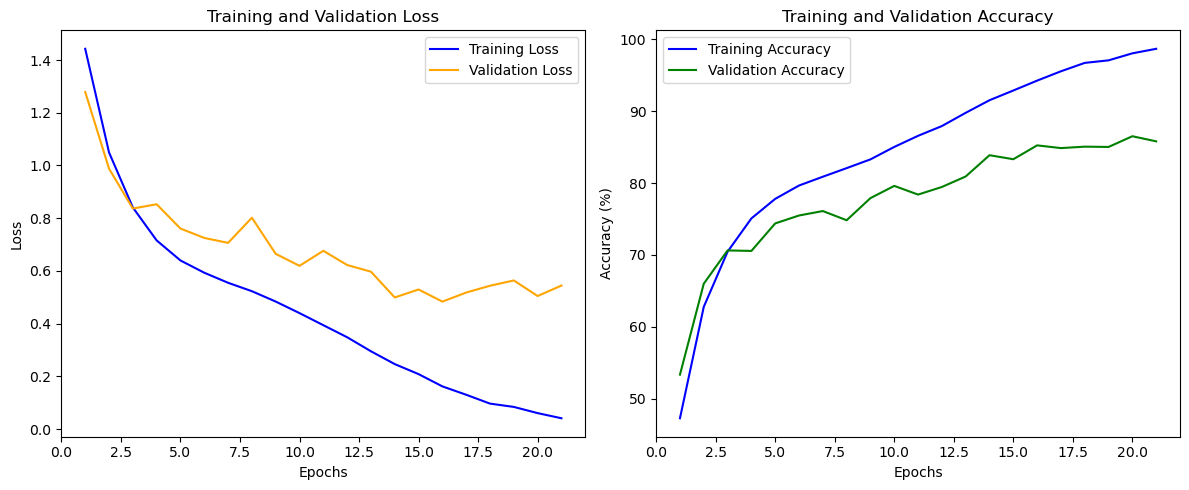

In [35]:
plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

MobileNet

In [10]:
mobilenet = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

# 冻结所有卷积层
for param in mobilenet.features.parameters():
    param.requires_grad = False

class MobileNetTransferLearning(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetTransferLearning, self).__init__()
        self.features = mobilenet.features
        # 新的全连接层
        self.fc1 = nn.Linear(1280, 512)  # 将 1280 输出维度映射到 512
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)  # 从 512 映射到 256
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.features(x)  # 特征提取部分
        x = x.mean([2, 3])  # Global Average Pooling (GAP)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(x)
        
        x = self.fc3(x)
        return x

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\a1941582/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 69.1MB/s]


In [15]:
trainloader, valloader, _ = get_data_loaders(64)
model2 = MobileNetTransferLearning(num_classes=10)
model2.to(device)  # 将模型移动到设备（GPU/CPU）

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0005, weight_decay=1e-3)

# 训练模型
train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(
    model2, trainloader, valloader, criterion, optimizer, 30, 'best_mobilenet.pth'
)

Epoch [1/30], Current LR: 0.000069, Train Loss: 1.6065, Train Accuracy: 46.99%, Val Loss: 1.0198, Val Accuracy: 70.59%
Epoch [2/30], Current LR: 0.000152, Train Loss: 0.9667, Train Accuracy: 68.72%, Val Loss: 0.7452, Val Accuracy: 75.42%
Epoch [3/30], Current LR: 0.000280, Train Loss: 0.8007, Train Accuracy: 72.99%, Val Loss: 0.6727, Val Accuracy: 76.85%
Epoch [4/30], Current LR: 0.000437, Train Loss: 0.7330, Train Accuracy: 75.03%, Val Loss: 0.6532, Val Accuracy: 77.57%
Epoch [5/30], Current LR: 0.000603, Train Loss: 0.7107, Train Accuracy: 75.92%, Val Loss: 0.6544, Val Accuracy: 77.24%
Epoch [6/30], Current LR: 0.000760, Train Loss: 0.6897, Train Accuracy: 76.20%, Val Loss: 0.6435, Val Accuracy: 77.41%
Epoch [7/30], Current LR: 0.000888, Train Loss: 0.6783, Train Accuracy: 76.68%, Val Loss: 0.6423, Val Accuracy: 77.69%
Epoch [8/30], Current LR: 0.000971, Train Loss: 0.6818, Train Accuracy: 76.66%, Val Loss: 0.6288, Val Accuracy: 78.14%
Epoch [9/30], Current LR: 0.001000, Train Loss: 

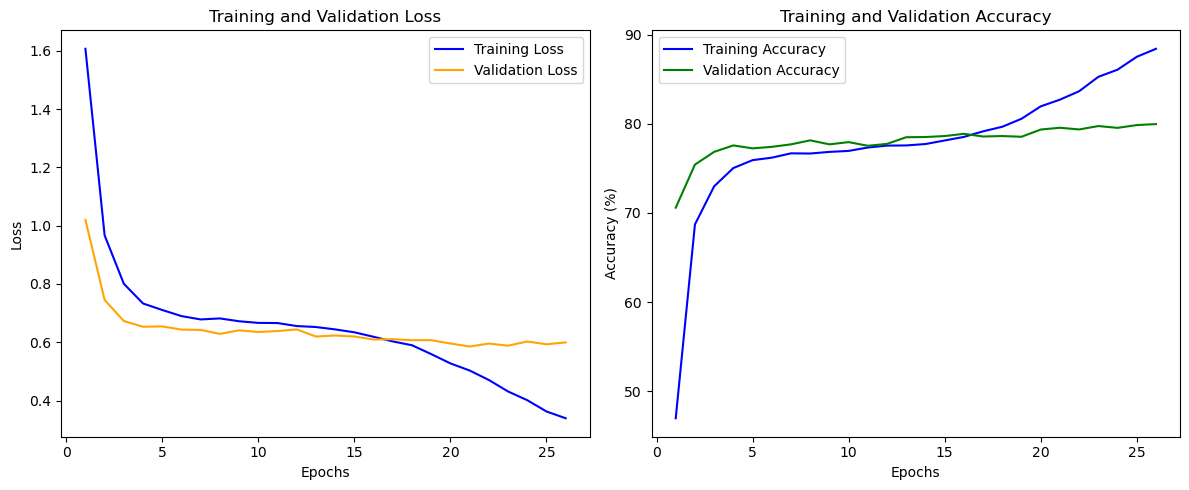

In [20]:
plot_learning_curves(train_losses2, val_losses2, train_accuracies2, val_accuracies2)

In [30]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        # 添加自适应平均池化层，保证输入图像尺寸为 32x32
        self.adaptive_pool = nn.AdaptiveAvgPool2d((32, 32))

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2, dilation=1)
        self.bn1 = nn.BatchNorm2d(32)

        # 第二层卷积：使用空洞卷积，输入 32x32，输出 32x32，池化后变为 16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=4, dilation=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出为 16x16

        # 第三层卷积：普通卷积，输入 16x16，输出 16x16，池化后变为 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, dilation=1)  # 普通卷积，dilation=1
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出为 8x8

        # 第四层卷积：普通卷积，输入 8x8，输出 8x8，池化后变为 4x4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, dilation=1)  # 普通卷积，dilation=1
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 使用自适应平均池化将特征图尺寸缩放至 4x4
        self.global_avg_pool = nn.AdaptiveAvgPool2d((4, 4))

        # 全连接层
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # 初始化权重
        self._initialize_weights()

    def forward(self, x):
        # 在开始时对输入图像进行自适应池化
        x = self.adaptive_pool(x)
        # 第一层卷积 + BN + ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        # 第二层卷积 + BN + ReLU + 池化
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        # 第三层卷积 + BN + ReLU + 池化
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        # 第四层卷积 + BN + ReLU + 池化
        x = self.pool3(F.relu(self.bn4(self.conv4(x))))
        # 自适应池化
        x = self.global_avg_pool(x)
        # 展平
        x = x.view(x.size(0), -1)
        # 全连接层 + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        # 使用 Kaiming 初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.zeros_(m.bias)

In [31]:
trainloader, valloader, _ = get_data_loaders(32)
model3 = CustomCNN(num_classes=10)
model3.to(device)  # 将模型移动到设备（GPU/CPU）

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.0001, weight_decay=1e-4)

# 训练模型
train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(
    model3, trainloader, valloader, criterion, optimizer, 30, 'best_custom.pth'
)

Epoch [1/30], Current LR: 0.000069, Train Loss: 6.7907, Train Accuracy: 17.17%, Val Loss: 2.1259, Val Accuracy: 23.56%
Epoch [2/30], Current LR: 0.000152, Train Loss: 2.1682, Train Accuracy: 20.57%, Val Loss: 1.9571, Val Accuracy: 29.48%
Epoch [3/30], Current LR: 0.000280, Train Loss: 2.0833, Train Accuracy: 22.45%, Val Loss: 1.8632, Val Accuracy: 32.24%
Epoch [4/30], Current LR: 0.000437, Train Loss: 2.0531, Train Accuracy: 22.56%, Val Loss: 1.8535, Val Accuracy: 31.71%
Epoch [5/30], Current LR: 0.000603, Train Loss: 1.9971, Train Accuracy: 24.21%, Val Loss: 1.7600, Val Accuracy: 33.44%
Epoch [6/30], Current LR: 0.000760, Train Loss: 1.9330, Train Accuracy: 26.00%, Val Loss: 1.6522, Val Accuracy: 37.53%
Epoch [7/30], Current LR: 0.000888, Train Loss: 1.8522, Train Accuracy: 28.21%, Val Loss: 1.5303, Val Accuracy: 41.77%
Epoch [8/30], Current LR: 0.000971, Train Loss: 1.8127, Train Accuracy: 29.78%, Val Loss: 1.5431, Val Accuracy: 43.37%
Epoch [9/30], Current LR: 0.001000, Train Loss: 

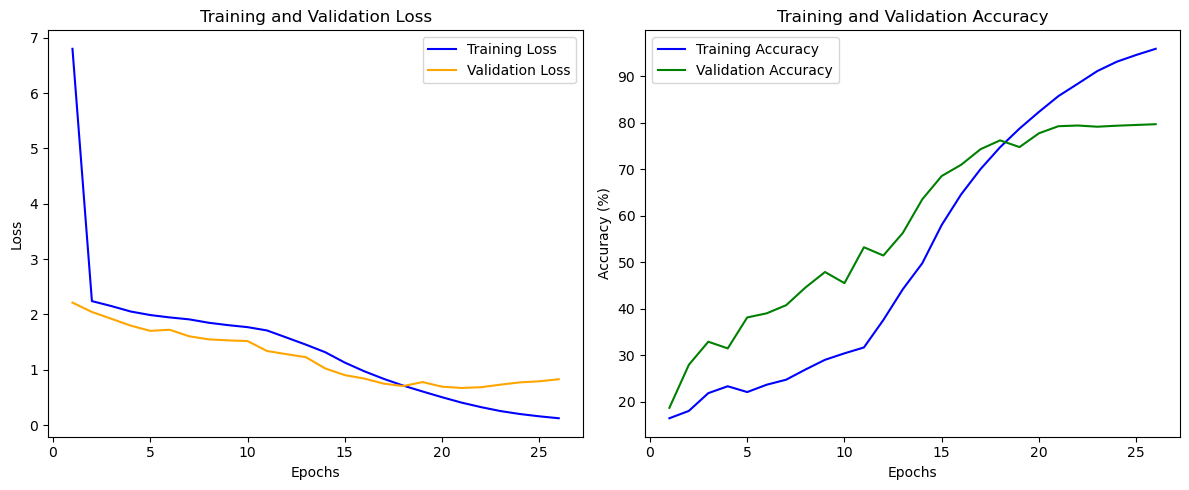

In [15]:
plot_learning_curves(train_losses3, val_losses3, train_accuracies3, val_accuracies3)

In [32]:
trainloader, valloader, _ = get_data_loaders(32)
model3 = CustomCNN(num_classes=10)
model3.to(device)  # 将模型移动到设备（GPU/CPU）

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# 训练模型
train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(
    model3, trainloader, valloader, criterion, optimizer, 30, 'best_custom_SGD.pth', 0.01
)

Epoch [1/30], Current LR: 0.000690, Train Loss: 2.9403, Train Accuracy: 11.65%, Val Loss: 2.2121, Val Accuracy: 17.19%
Epoch [2/30], Current LR: 0.001523, Train Loss: 2.1873, Train Accuracy: 15.73%, Val Loss: 1.9574, Val Accuracy: 22.62%
Epoch [3/30], Current LR: 0.002800, Train Loss: 2.0523, Train Accuracy: 20.02%, Val Loss: 1.8301, Val Accuracy: 30.71%
Epoch [4/30], Current LR: 0.004367, Train Loss: 1.9782, Train Accuracy: 23.93%, Val Loss: 1.7312, Val Accuracy: 34.50%
Epoch [5/30], Current LR: 0.006034, Train Loss: 1.8894, Train Accuracy: 27.68%, Val Loss: 1.6571, Val Accuracy: 34.42%
Epoch [6/30], Current LR: 0.007601, Train Loss: 1.8317, Train Accuracy: 30.12%, Val Loss: 1.5365, Val Accuracy: 41.79%
Epoch [7/30], Current LR: 0.008878, Train Loss: 1.7671, Train Accuracy: 32.90%, Val Loss: 1.4903, Val Accuracy: 44.35%
Epoch [8/30], Current LR: 0.009711, Train Loss: 1.6952, Train Accuracy: 36.14%, Val Loss: 1.4314, Val Accuracy: 45.97%
Epoch [9/30], Current LR: 0.010000, Train Loss: 

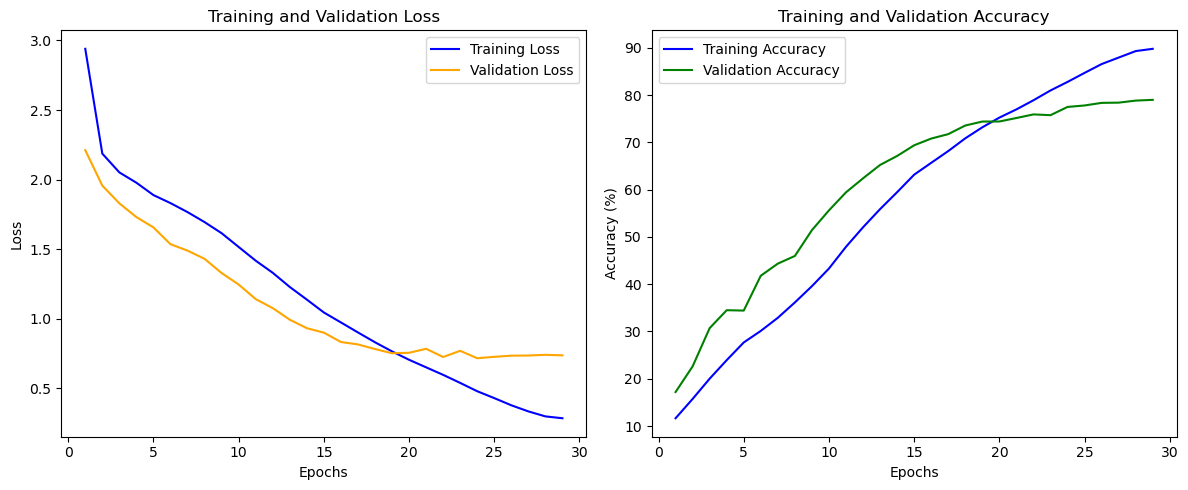

In [33]:
plot_learning_curves(train_losses3, val_losses3, train_accuracies3, val_accuracies3)

In [50]:
class Custom5layerCNN(nn.Module):
    def __init__(self, num_classes):
        super(Custom5layerCNN, self).__init__()

        # 添加自适应平均池化层，保证输入图像尺寸为 32x32
        self.adaptive_pool = nn.AdaptiveAvgPool2d((32, 32))

        # 第一层卷积：输入 32x32，输出 32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2, dilation=1)
        self.bn1 = nn.BatchNorm2d(32)

        # 第二层卷积：使用空洞卷积，输入 32x32，输出 32x32，池化后变为 16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=4, dilation=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出为 16x16

        # 第三层卷积：普通卷积，输入 16x16，输出 16x16，池化后变为 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, dilation=1)  # 普通卷积，dilation=1
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出为 8x8

        # 第四层卷积：普通卷积，输入 8x8，输出 8x8，池化后变为 4x4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, dilation=1)  # 普通卷积，dilation=1
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 新增第五层卷积，输入 4x4，输出 4x4
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1, dilation=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 输出为 2x2

        # 使用自适应平均池化将特征图尺寸缩放至 2x2
        self.global_avg_pool = nn.AdaptiveAvgPool2d((2, 2))

        # 全连接层
        self.fc1 = nn.Linear(512 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # 初始化权重
        self._initialize_weights()

    def forward(self, x):
        # 在开始时对输入图像进行自适应池化
        x = self.adaptive_pool(x)
        # 第一层卷积 + BN + ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        # 第二层卷积 + BN + ReLU + 池化
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        # 第三层卷积 + BN + ReLU + 池化
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        # 第四层卷积 + BN + ReLU + 池化
        x = self.pool3(F.relu(self.bn4(self.conv4(x))))
        # 第五层卷积 + BN + ReLU + 池化
        x = self.pool4(F.relu(self.bn5(self.conv5(x))))
        # 自适应池化
        x = self.global_avg_pool(x)
        # 展平
        x = x.view(x.size(0), -1)
        # 全连接层 + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        # 使用 Kaiming 初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                init.ones_(m.weight)
                init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                init.zeros_(m.bias)

In [51]:
trainloader, valloader, _ = get_data_loaders(32)
model4 = Custom5layerCNN(num_classes=10)
model4.to(device)  # 将模型移动到设备（GPU/CPU）

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.0001, weight_decay=1e-4)

# 训练模型
train_losses4, train_accuracies4, val_losses4, val_accuracies4 = train_model(
    model4, trainloader, valloader, criterion, optimizer, 30, 'best_5custom.pth'
)

Epoch [1/30], Current LR: 0.000069, Train Loss: 4.2207, Train Accuracy: 20.87%, Val Loss: 1.9463, Val Accuracy: 30.71%
Epoch [2/30], Current LR: 0.000152, Train Loss: 2.0287, Train Accuracy: 27.64%, Val Loss: 1.7299, Val Accuracy: 39.47%
Epoch [3/30], Current LR: 0.000280, Train Loss: 1.9622, Train Accuracy: 28.92%, Val Loss: 1.7341, Val Accuracy: 37.41%
Epoch [4/30], Current LR: 0.000437, Train Loss: 1.9350, Train Accuracy: 28.04%, Val Loss: 1.5883, Val Accuracy: 41.50%
Epoch [5/30], Current LR: 0.000603, Train Loss: 1.8284, Train Accuracy: 31.23%, Val Loss: 1.5961, Val Accuracy: 42.26%
Epoch [6/30], Current LR: 0.000760, Train Loss: 1.7612, Train Accuracy: 33.30%, Val Loss: 1.4750, Val Accuracy: 46.79%
Epoch [7/30], Current LR: 0.000888, Train Loss: 1.6844, Train Accuracy: 36.43%, Val Loss: 1.4112, Val Accuracy: 48.89%
Epoch [8/30], Current LR: 0.000971, Train Loss: 1.5856, Train Accuracy: 39.26%, Val Loss: 1.3317, Val Accuracy: 49.94%
Epoch [9/30], Current LR: 0.001000, Train Loss: 

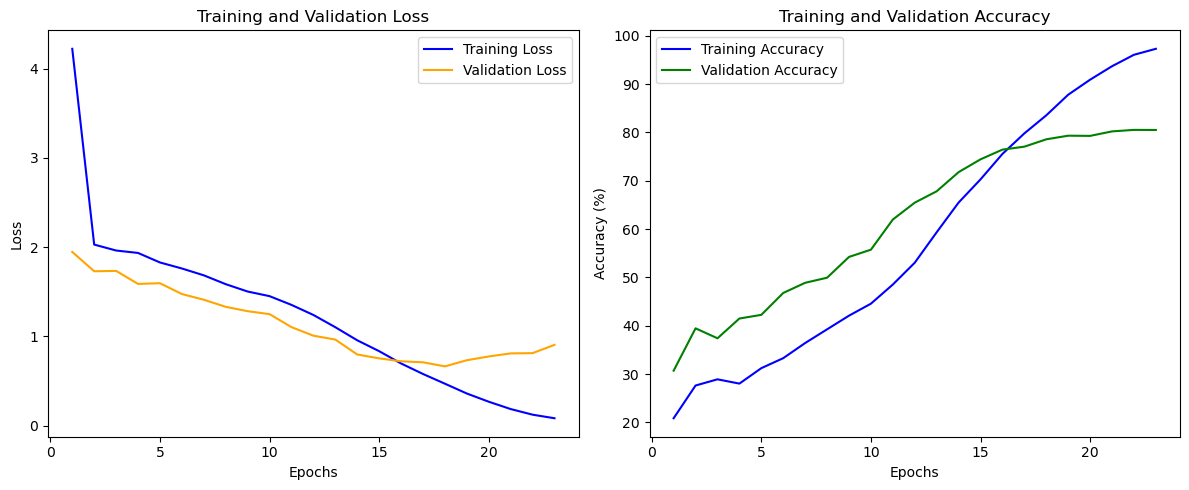

In [52]:
plot_learning_curves(train_losses4, val_losses4, train_accuracies4, val_accuracies4)

In [41]:
model = ResNet18().to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [42]:
def get_test_predictions(model, testloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

In [43]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = (y_true == y_pred).sum()  # 计算正确预测的数量
    total_predictions = len(y_true)  # 总预测数量
    accuracy = correct_predictions / total_predictions * 100  # 计算准确度百分比
    return accuracy

In [44]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.show()

In [45]:
def evaluate_model(model, testloader, classes):
    y_true, y_pred = get_test_predictions(model, testloader)
    test_accuracy = calculate_accuracy(y_true, y_pred)
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    plot_confusion_matrix(y_true, y_pred, classes, normalize=True)

Test Accuracy: 84.67%


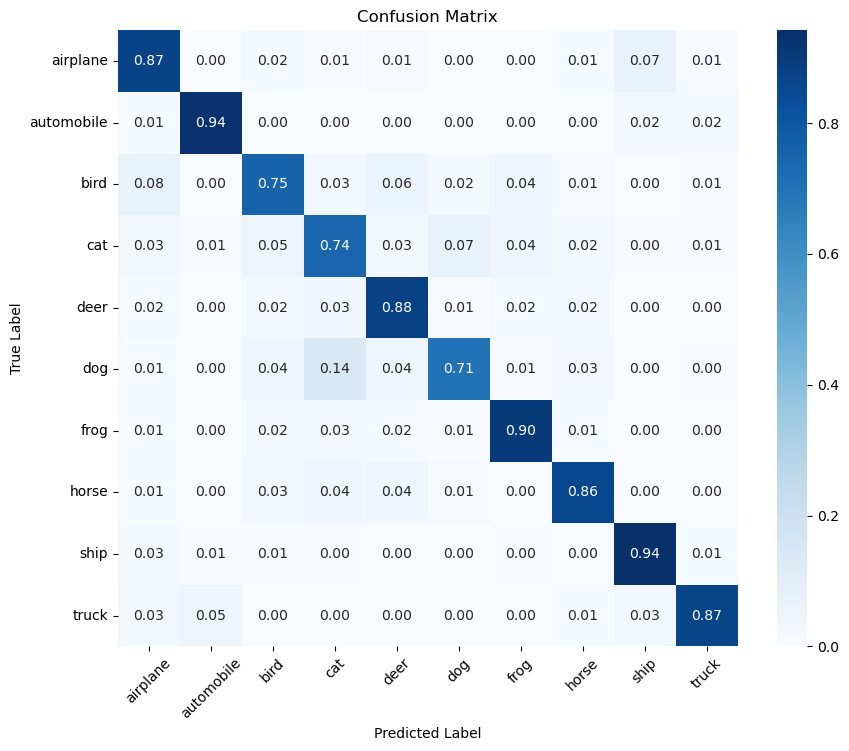

In [46]:
_, _, testloader = get_data_loaders(32)
evaluate_model(model, testloader, class_names)